In [1]:
import pandas as pd
import numpy as np
from typing import List
import argparse
import warnings
import numpy as np
import pandas as pd

from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.utils import load_synthesizer
from sdv.sampling import Condition

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load data and processing if necessary

In [2]:
dat = pd.read_csv('data/ukb/OSA_test2.csv')

In [3]:
dat.info()
dat['OSA'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221269 entries, 0 to 221268
Data columns (total 70 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   f_eid        221269 non-null  int64  
 1   f_20016_0_0  70974 non-null   float64
 2   f_20016_1_0  9711 non-null    float64
 3   f_4282_0_0   23876 non-null   float64
 4   f_4282_1_0   0 non-null       float64
 5   f_20023_0_0  220118 non-null  float64
 6   f_20023_1_0  9755 non-null    float64
 7   IID          221269 non-null  int64  
 8   PC1          221269 non-null  float64
 9   PC2          221269 non-null  float64
 10  Male         221269 non-null  int64  
 11  BMI          221269 non-null  float64
 12  Age          221269 non-null  float64
 13  Date         2304 non-null    object 
 14  OSA          221269 non-null  int64  
 15  APOE_e4      221269 non-null  int64  
 16  snoring      221138 non-null  float64
 17  centre       221269 non-null  object 
 18  f_25887_2_0  19426 non-n

OSA
0    218965
1      2304
Name: count, dtype: int64

Drop columns of too many missing values and rows with any missing values.

In [4]:
dat = dat.drop(columns=['f_20023_0_0', 'f_20023_1_0', 'f_4282_0_0', 'f_4282_1_0', 'Date', 'f_20016_0_0', 'f_20016_1_0', "f_eid", "IID"])
dat = dat.drop(columns=[col for col in dat.columns if '_3_0' in col])
dat = dat.dropna()
dat.info()

dat['OSA'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 19416 entries, 2 to 221264
Data columns (total 35 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PC1          19416 non-null  float64
 1   PC2          19416 non-null  float64
 2   Male         19416 non-null  int64  
 3   BMI          19416 non-null  float64
 4   Age          19416 non-null  float64
 5   OSA          19416 non-null  int64  
 6   APOE_e4      19416 non-null  int64  
 7   snoring      19416 non-null  float64
 8   centre       19416 non-null  object 
 9   f_25887_2_0  19416 non-null  float64
 10  f_25886_2_0  19416 non-null  float64
 11  f_25003_2_0  19416 non-null  float64
 12  f_25004_2_0  19416 non-null  float64
 13  f_25001_2_0  19416 non-null  float64
 14  f_25002_2_0  19416 non-null  float64
 15  f_25005_2_0  19416 non-null  float64
 16  f_25006_2_0  19416 non-null  float64
 17  f_25007_2_0  19416 non-null  float64
 18  f_25008_2_0  19416 non-null  float64
 19  f_25009_

OSA
0    19280
1      136
Name: count, dtype: int64

From the above, we can see the number of OSA patients is much smaller than the number of non-OSA patients. To address this class imbalance, we can use techniques such as oversampling the minority class, undersampling the majority class, or using synthetic data generation methods like SMOTE (Synthetic Minority Over-sampling Technique). In this project, we will use a `GAN-based approach` to generate synthetic OSA patient data to balance the dataset.

Fill Abandoned(-1), refused (7), don't know (9) and missing (.) with NaN.  
Drop missing values in the target variable (brain region volumn)

In [5]:
# to-do

## Train GAN

In [6]:
# -----------------------------------------------------------------------------
# Utility functions
# -----------------------------------------------------------------------------

def clean_missing_codes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert UKB-style codes for 'Refused', 'Don't know', or 'Missing'
    to NaN for numeric columns, and certain strings to NaN for object columns.

    This does NOT try to interpret 88/888 etc., only classic 7/9 patterns.
    """
    missing_codes = {
        7, 9,
        77, 99,
        777, 999,
        7777, 9999,
        77777, 99999,
    }

    # Numeric columns: map code values to NaN
    num_cols = df.select_dtypes(include=["number"]).columns
    for col in num_cols:
        df[col] = df[col].mask(df[col].isin(missing_codes))

    # String columns: common literal labels
    text_missing = {"Refused", "REFUSED", "Don't know", "DON'T KNOW", "Missing", "MISSING"}
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        df[col] = df[col].replace(list(text_missing), np.nan)

    return df


def train_sdv_synthesizer(df: pd.DataFrame, 
                          epoch: int=300, 
                          batch_size: int=500, 
                          lr: float|list[float]=1e-4
                          ) -> CTGANSynthesizer:
    """
    Train an SDV CTGAN synthesizer on the dataframe, treating 'osa_diag' as
    a conditional variable for later balanced sampling.
    """
    if "OSA" not in df.columns:
        raise ValueError("'OSA' column must exist in dataframe before training.")
    # Optionally drop unique identifier columns (e.g., SEQN) to avoid overfitting IDs
    # df = df.drop(columns=["f_eid", "IID"])
    
    # Build metadata automatically
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    # Ensure osa and date columns are treated as categorical / datetime
    metadata.update_column(
        column_name="OSA",
        sdtype="categorical",
    )
    for col_id in ["centre"]:
        metadata.update_column(
            column_name=col_id,
            sdtype="datetime",
            datetime_format="%Y-%m-%d"
        )
    metadata.save_to_json(f"results/metadata_ukb_osa_nomissing.json", mode="overwrite")
    
    # determine lr
    if isinstance(lr, float):
        lr = [lr, lr]
    elif isinstance(lr, list):
        if len(lr) != 2:
            raise ValueError("If lr is a list, it must have exactly two elements: [discriminator_lr, generator_lr]")
        
    # Create and train synthesizer
    synthesizer = CTGANSynthesizer(
        metadata,
        enforce_rounding=True,
        epochs=epoch,
        batch_size=batch_size,
        generator_lr = lr[0],
        discriminator_lr = lr[1],
        discriminator_steps=3,
        verbose=True,
        cuda=True,        # set to True if you want to use GPU and have one
    )
    # handle missing values automatically
    # has to make a function for this
    
    synthesizer.fit(df)

    return synthesizer


def generate_balanced_samples(
    synthesizer,
    n_samples: int = 40000,
    label_col: str = "OSA",
):
    """
    Generate synthetic samples with equal numbers of 0 and 1 in `label_col`
    using SDV conditional sampling.
    """
    if n_samples % 2 != 0:
        raise ValueError("n_samples must be even to generate a balanced dataset.")

    half = n_samples // 2

    # One condition for label = 0, one for label = 1
    cond_0 = Condition(
        num_rows=half,
        column_values={label_col: 0},
    )
    cond_1 = Condition(
        num_rows=half,
        column_values={label_col: 1},
    )

    synthetic = synthesizer.sample_from_conditions(
        conditions=[cond_0, cond_1]
        # you can also tweak:
        # batch_size=...,
        # max_tries_per_batch=...,
    )

    return synthetic

The loss of the Generator and the Discriminator are expected to be stable around a negative value close to zero. The following are the major hyperparameters that we optimized for this dataset:

In [7]:
random_state = 42
lr = [1e-5, 1e-4]
batch_size = 2000
synthesizer_file = f'results/ukb_synthesizer_osa.pkl'

In [8]:
# -------------------------------------------------------------------------
# 1. Train SDV synthesizer (CTGAN) with osa_diag as conditional variable
# -------------------------------------------------------------------------
print("Training SDV CTGAN synthesizer (conditional on OSA)...")
np.random.seed(random_state)

synthesizer = train_sdv_synthesizer(dat, epoch = 1000, lr=lr, batch_size=batch_size)

Training SDV CTGAN synthesizer (conditional on OSA)...


Gen. (-1.18) | Discrim. (-0.44): 100%|██████████| 1000/1000 [31:08<00:00,  1.87s/it]


In [9]:
fig = synthesizer.get_loss_values_plot()
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.show()
with open(f'results/ukb_synthesizer_osa_loss.png', 'wb') as f:
    f.write(fig.to_image(format='png', width=1600, height=800))

Save the trained GAN model for future use.

In [10]:
synthesizer.save(synthesizer_file)
print(f"Synthesizer saved to {synthesizer_file}")

Synthesizer saved to results/ukb_synthesizer_osa.pkl


## Sample real data, conditional on OSA diagnosis

In [11]:
synthesizer = load_synthesizer(synthesizer_file)

In [12]:
n_samples = 40000

# -------------------------------------------------------------------------
# 2. Generate balanced synthetic samples
# -------------------------------------------------------------------------
print(f"Generating {n_samples} synthetic samples balanced on osa_diag...")
synth = generate_balanced_samples(
    synthesizer=synthesizer,
    n_samples=n_samples,
    label_col="OSA",
)

print("Synthetic osa_diag value counts:")
print(synth["OSA"].value_counts(dropna=False))

Generating 40000 synthetic samples balanced on osa_diag...


Sampling conditions: 100%|██████████| 40000/40000 [00:16<00:00, 2455.99it/s]

Synthetic osa_diag value counts:
OSA
0    20000
1    20000
Name: count, dtype: int64


In [13]:
output_synth = 'results/ukb_synthetic_osa.parquet'
output_csv = 'results/ukb_synthetic_osa.csv'
# -------------------------------------------------------------------------
# 3. Save synthetic data
# -------------------------------------------------------------------------
print(f"Saving synthetic balanced data to: {output_synth}")
synth.to_parquet(output_synth, index=False)
synth.to_csv(output_csv)
print("Done.")

Saving synthetic balanced data to: results/ukb_synthetic_osa.parquet
Done.


## Evaluating real v.s. synthetic

The following will check the data type, category and range of synthesized variables. We expect the synthetic has the same data type, category and range as the real data (overall score = 100%).

In [14]:
from sdv.evaluation.single_table import run_diagnostic
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(dat)
diagnostic = run_diagnostic(
    real_data=dat,
    synthetic_data=synth,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 35/35 [00:00<00:00, 663.53it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 391.88it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



Continue to check the statistical similarity.

In [15]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    dat,
    synth,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 35/35 [00:00<00:00, 66.32it/s]|
Column Shapes Score: 91.65%

(2/2) Evaluating Column Pair Trends: |██████████| 595/595 [00:04<00:00, 121.03it/s]|
Column Pair Trends Score: 88.56%

Overall Score (Average): 90.1%



In [16]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=dat,
    synthetic_data=synth,
    column_name='f_25886_2_0',
    metadata=metadata
)

# fig.show()
fig.write_image('images/numeric_column_distribution.pdf')

In [17]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=dat,
    synthetic_data=synth,
    column_names=['OSA', 'Male'],
    metadata=metadata
)

# fig.show()
fig.write_image('images/balanced_OSA_sex.pdf')

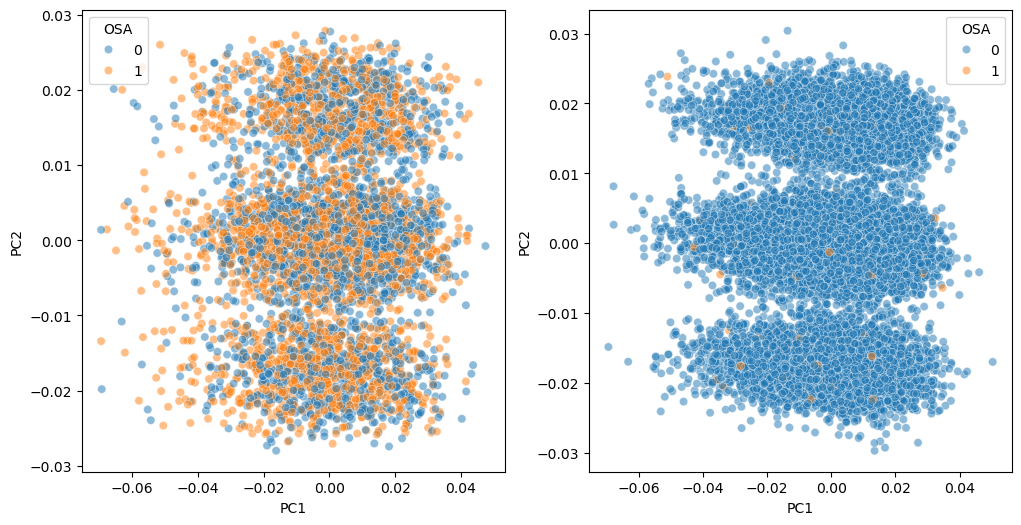

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=synth.sample(n=5000), x='PC1', y='PC2', hue='OSA', alpha = 0.5, ax=axes[0])
sns.scatterplot(data=dat, x='PC1', y='PC2', hue='OSA', alpha = 0.5, ax=axes[1])
fig.savefig('images/PC_OSA.pdf')